<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/density_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyfftw
!pip install powerbox

     |████████████████████████████████| 2.6 MB 5.4 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import powerbox as pbox
import time

### Create a 2D lognormal density field

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


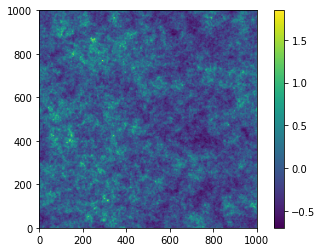

In [3]:
lnpb = pbox.LogNormalPowerBox(
    N=256,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)
plt.imshow(lnpb.delta_x(),extent=(0,1000,0,1000))
plt.colorbar()
plt.show()

## Create a discrete sampling of the field. 
It looks like it is tracing the above field.

/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


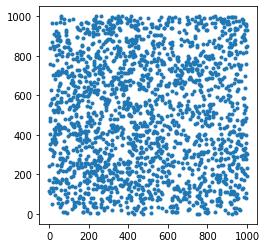

In [6]:
sample=lnpb.create_discrete_sample(nbar=2.0E-3, min_at_zero=True)
plt.plot(sample[:,0],sample[:,1],'.')
ax=plt.gca()
ax.set_aspect('equal', adjustable='box')

### Create a 3D field, create a discrete Sample, and rebin that sample on a grid

In [7]:
start=time.time()

lnpb = pbox.LogNormalPowerBox(
    N=64,                     # Number of grid-points in the box
    dim=3,                     # 2D box
    pk = lambda k: 0.1*k**-2., # The power-spectrum
    boxlength = 1000.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                # Use the same seed as our powerbox
)

ln_samples = lnpb.create_discrete_sample(nbar=1.0E-4, min_at_zero=True)

grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000),(0,1000)],bins=64)

print(time.time()-start)

0.15941238403320312


/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


In [4]:
inputs=[]
outputs=[]

for i in range(100):
  lnpb = pbox.LogNormalPowerBox(N=64,dim=3,pk = lambda k: 0.1*k**-2.,boxlength = 1000.0,seed = i+1000)
  ln_samples = lnpb.create_discrete_sample(nbar=1.0E-4, min_at_zero=True)
  grid,edge=np.histogramdd(ln_samples,range=[(0,1000),(0,1000),(0,1000)],bins=64)
  inputs.append(grid)
  outputs.append(lnpb.delta_x())


/usr/local/lib/python3.7/dist-packages/powerbox/powerbox.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gpa = np.abs(dft.fft(gca, L=self.boxlength, a=self.fourier_a, b=self.fourier_b))[0]


In [34]:
print(np.shape(outputs[:5]))
split=70
test_data=tf.expand_dims(outputs[split:],-1)
train_data=tf.expand_dims(outputs[:split],-1)

test_truth=tf.expand_dims(outputs[split:],-1)
train_truth=tf.expand_dims(outputs[:split],-1)

print(np.shape(train_data))
print(np.shape(train_truth))
print(np.shape(test_data))
print(np.shape(test_truth))

(5, 64, 64, 64)
(70, 64, 64, 64, 1)
(70, 64, 64, 64, 1)
(30, 64, 64, 64, 1)
(30, 64, 64, 64, 1)


In [10]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Input,BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import AveragePooling3D, Conv3DTranspose
from tensorflow.keras.layers import concatenate, Concatenate


2.6.0


In [46]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.02)
#lrelu='relu'

drop=0.15 
def pool(layer):
  #return MaxPooling2D((2, 2))(layer)
  return AveragePooling3D((2, 2,2))(layer)

def build_model(input_layer, start_neurons):
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = pool(conv1)
    pool1 = Dropout(drop)(pool1)

    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = pool(conv2)
    pool2 = Dropout(drop)(pool2)

    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = pool(conv3)
    pool3 = Dropout(drop)(pool3)

    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = pool(conv4)
    pool4 = Dropout(drop)(pool4)

    # Middle
    convm = Conv3D(start_neurons * 16, (3, 3, 3), activation=lrelu, padding="same")(pool4)
    convm = BatchNormalization()(convm)
    convm = Conv3D(start_neurons * 16, (3, 3, 3), activation=lrelu, padding="same")(convm)
    convm = BatchNormalization()(convm)

    deconv4 = Conv3DTranspose(start_neurons * 8, (3, 3, 3), strides=(2, 2,2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(drop)(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(uconv4)
    #uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=lrelu, padding="same")(uconv4)
    #uconv4 = BatchNormalization()(uconv4)

    deconv3 = Conv3DTranspose(start_neurons * 4, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(drop)(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(uconv3)
    #uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=lrelu, padding="same")(uconv3)
    #uconv3 = BatchNormalization()(uconv3)

    deconv2 = Conv3DTranspose(start_neurons * 2, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(drop)(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv2)
    #uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=lrelu, padding="same")(uconv2)
    #uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv3DTranspose(start_neurons * 1, (3, 3, 3), strides=(2, 2,2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(drop)(uconv1)
    uconv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=lrelu, padding="same")(uconv1)
    #uconv1 = BatchNormalization()(uconv1)
    
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer = Conv3D(1, (1,1,1), padding="same")(uconv1)
    model=Model(inputs=[input_layer],outputs=[output_layer])
    return model

def customLoss(yTrue,yPred):
    import numpy as np
    import tensorflow.keras.backend as K

    #yTrueN=yTrue[0,4:60,4:60]
    #yPredN=yPred[0,4:60,4:60]
    
    yTrue=K.cast(yTrue, dtype='float')
    yPred=K.cast(yPred, dtype='float')
    
    yTrue=K.flatten(yTrue)
    yPred=K.flatten(yPred)

    #L=tf.math.reduce_sum((tf.math.log(tf.math.cosh(yTrue - yPred)))) #log 
    #L=tf.math.reduce_sum(tf.abs(yTrue-yPred))
    L=tf.math.reduce_sum(tf.pow((yTrue-yPred),2))
    #L=tf.math.reduce_sum(tf.pow((yTrue-yPred),4))

    return L

img_size_target=64

input_layer = Input((img_size_target, img_size_target,img_size_target, 1))
model_error = build_model(input_layer, 16)
#model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=["accuracy"])

opt=tf.keras.optimizers.Adam(learning_rate=0.0003)
model_error.compile(optimizer=opt,loss=customLoss)

#model_error.compile(optimizer='Adam', loss="mean_squared_error", metrics=["accuracy"])
model_error.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d_152 (Conv3D)             (None, 64, 64, 64, 1 448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 64, 64, 64, 1 64          conv3d_152[0][0]                 
__________________________________________________________________________________________________
conv3d_153 (Conv3D)             (None, 64, 64, 64, 1 6928        batch_normalization_80[0][0]     
____________________________________________________________________________________________

In [47]:
results = model_error.fit(train_data, train_truth, epochs=150, validation_data=(test_data, test_truth),batch_size=10)

Epoch 1/150
7/7 [==============================] - 20s 3s/step - loss: 636520.4375 - val_loss: 3261.5146
Epoch 2/150
7/7 [==============================] - 17s 2s/step - loss: 244681.9375 - val_loss: 3209.0432
Epoch 3/150
7/7 [==============================] - 17s 2s/step - loss: 113014.5938 - val_loss: 3302.4697
Epoch 4/150
7/7 [==============================] - 17s 3s/step - loss: 62146.9844 - val_loss: 3301.2317
Epoch 5/150
7/7 [==============================] - 17s 3s/step - loss: 39161.7305 - val_loss: 3257.4089
Epoch 6/150
7/7 [==============================] - 17s 3s/step - loss: 27546.3887 - val_loss: 3707.1978
Epoch 7/150
7/7 [==============================] - 17s 2s/step - loss: 21125.5117 - val_loss: 3963.8213
Epoch 8/150
7/7 [==============================] - 17s 2s/step - loss: 17238.9160 - val_loss: 3581.4021
Epoch 9/150
7/7 [==============================] - 17s 3s/step - loss: 14523.7539 - val_loss: 3780.5854
Epoch 10/150
7/7 [==============================] - 17s 3s/st

KeyboardInterrupt: ignored

In [48]:
preds = model_error.predict(test_data, verbose=1)

1/1 [==============================] - 1s 540ms/step


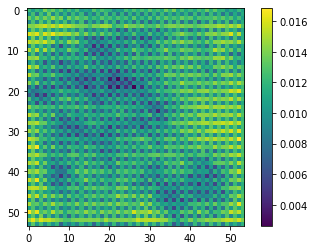

In [49]:
plt.imshow(preds[1,10,5:-5,5:-5,0])
plt.colorbar()

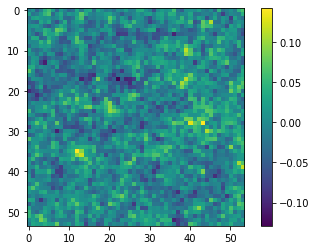

In [50]:
plt.imshow(test_truth[1,10,5:-5,5:-5,0])
plt.colorbar()